In [1]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

sns.set_theme(style="whitegrid",
              context="notebook",
              font_scale=1.2,
              )

plot_save_path = 'C:/Users/Mees/OneDrive - HvA/Documents/GitHub/MDDB-Master-Thesis-Cold-Start-problem-in-RecSys/plots/'
table_save_path = 'C:/Users/Mees/OneDrive - HvA/Documents/GitHub/MDDB-Master-Thesis-Cold-Start-problem-in-RecSys/tables/'
api = wandb.Api()

# Performance evaluation of Reinforcement Learning algorithm

### Loss function

In [2]:
# Project is specified by <entity/project-name>
runs = api.runs("universityofappliedsciencesamsterdam/RecSys RL", filters={"tags": "selectie"}, )

summary_list, config_list, id_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    id_list.append(run.id)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "run_id": id_list
    })

# Select the columns we want to keep
cols_to_keep = ['run_id', 'dataset_name', 'reward_dict', 'n_history']

# the summary column is a dictionary we can expand it to multiple columns and keep only the columns we want
runs_df = pd.concat([runs_df.drop(['config'], axis=1), runs_df['config'].apply(pd.Series)], axis=1)[cols_to_keep]

# replace diginetica with Diginetica and retailrocket with Retailrocket
runs_df['dataset'] = runs_df['dataset_name'].str.replace('diginetica', 'Diginetica').str.replace('retailrocket', 'Retailrocket')

runs_df = runs_df.drop(['dataset_name'], axis=1)

display('runs df:')
display(runs_df)


runs = api.runs("universityofappliedsciencesamsterdam/RecSys RL", filters={"tags": "selectie"})

# Initialize a list to store the loss data
data = []

# Loop through each run
for run in runs:
    # Get the run history (all steps)
    history = run.history(keys=["loss"])
    
    # Add the run id and step to the dataframe
    history["run_id"] = run.id
    history["step"] = history.index
    history["run_name"] = run.name
    
    # Append the history dataframe to the list
    data.append(history)

# Concatenate all the dataframes in the list
df = pd.concat(data)

# Reset the index of the dataframe
df.reset_index(drop=True, inplace=True)

# Display the dataframe
display('loss df:')
display(df)

'runs df:'

,run_id,reward_dict,n_history,dataset
0,un0nj4fp,"{0: 3, 1: 10}",10,Diginetica
1,qemzk45g,"{0: 3, 1: 10}",15,Diginetica
2,gdnaqjlm,"{0: 3, 1: 10}",100,Diginetica
3,yubsx58u,"{0: 0, 1: 10}",100,Diginetica
4,l4hrga4f,"{0: 3, 1: 10}",5,Diginetica
5,ymlk74xj,"{0: 0, 1: 10}",5,Diginetica
6,m6ftokad,"{0: 0, 1: 10}",10,Diginetica
7,nxovith2,"{0: 0, 1: 10}",15,Diginetica
8,w4145el8,"{0: 0, 1: 10}",5,Diginetica
9,plroqf96,"{0: 0, 1: 10}",10,Diginetica


'loss df:'

,_step,loss,run_id,step,run_name
0,105,268768800.0,un0nj4fp,0,silvery-pine-13
1,122,115997760.0,un0nj4fp,1,silvery-pine-13
2,136,182188096.0,un0nj4fp,2,silvery-pine-13
3,164,215842464.0,un0nj4fp,3,silvery-pine-13
4,236,171660480.0,un0nj4fp,4,silvery-pine-13
...,...,...,...,...,...
8995,12596,58729828.0,w78z63yz,495,effortless-star-54
8996,12638,96280880.0,w78z63yz,496,effortless-star-54
8997,12652,92736904.0,w78z63yz,497,effortless-star-54
8998,12659,104981632.0,w78z63yz,498,effortless-star-54


In [3]:
# left join the df to the runs_df
runs_df = pd.merge(runs_df, df, on='run_id', how='left')

# Rename the reward_dict column to reward function with corresponding values
to_replace = ['{0: 3, 1: 10}', 
              '{0: 0, 1: 10}',
              '{0: 3, 1: 8, 2: 10}',
              '{0: 0, 1: 8, 2: 10}']

replace_with = ['click=3, purchase=10', 
                'click=0, purchase=10',
                'click=3, addtocart=8, purchase=10',
                'click=0, addtocart=8, purchase=10']

replacement_dict = {to_replace[i]: replace_with[i] for i in range(len(to_replace))}

runs_df['reward func'] = runs_df['reward_dict'].replace(replacement_dict, regex=True)
runs_df['reward func'].unique()

array(['click=3, purchase=10', 'click=0, purchase=10',
       'click=3, addtocart=8, purchase=10',
       'click=0, addtocart=8, purchase=10'], dtype=object)

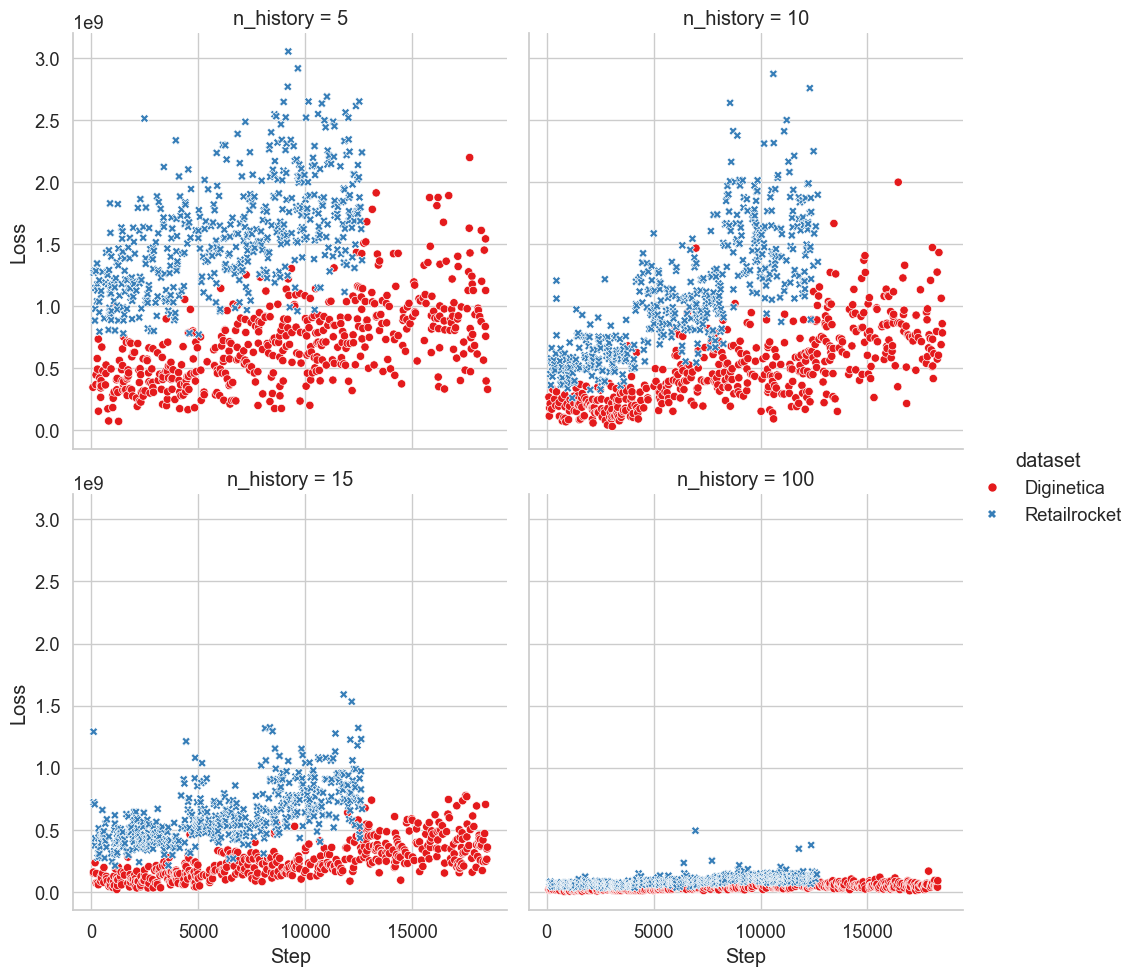

In [4]:
# visualize the loss
g = sns.relplot(data=runs_df[runs_df['reward func'].isin(['click=3, purchase=10', 'click=3, addtocart=8, purchase=10'])], kind='scatter', x='_step', y='loss', 
            col='n_history', 
            col_wrap=2,
            hue='dataset',	
            style='dataset',
            palette='Set1',
            facet_kws={'sharey': True})
g.set_axis_labels("Step", "Loss")
g.savefig(plot_save_path + 'loss_across_datasets.png')

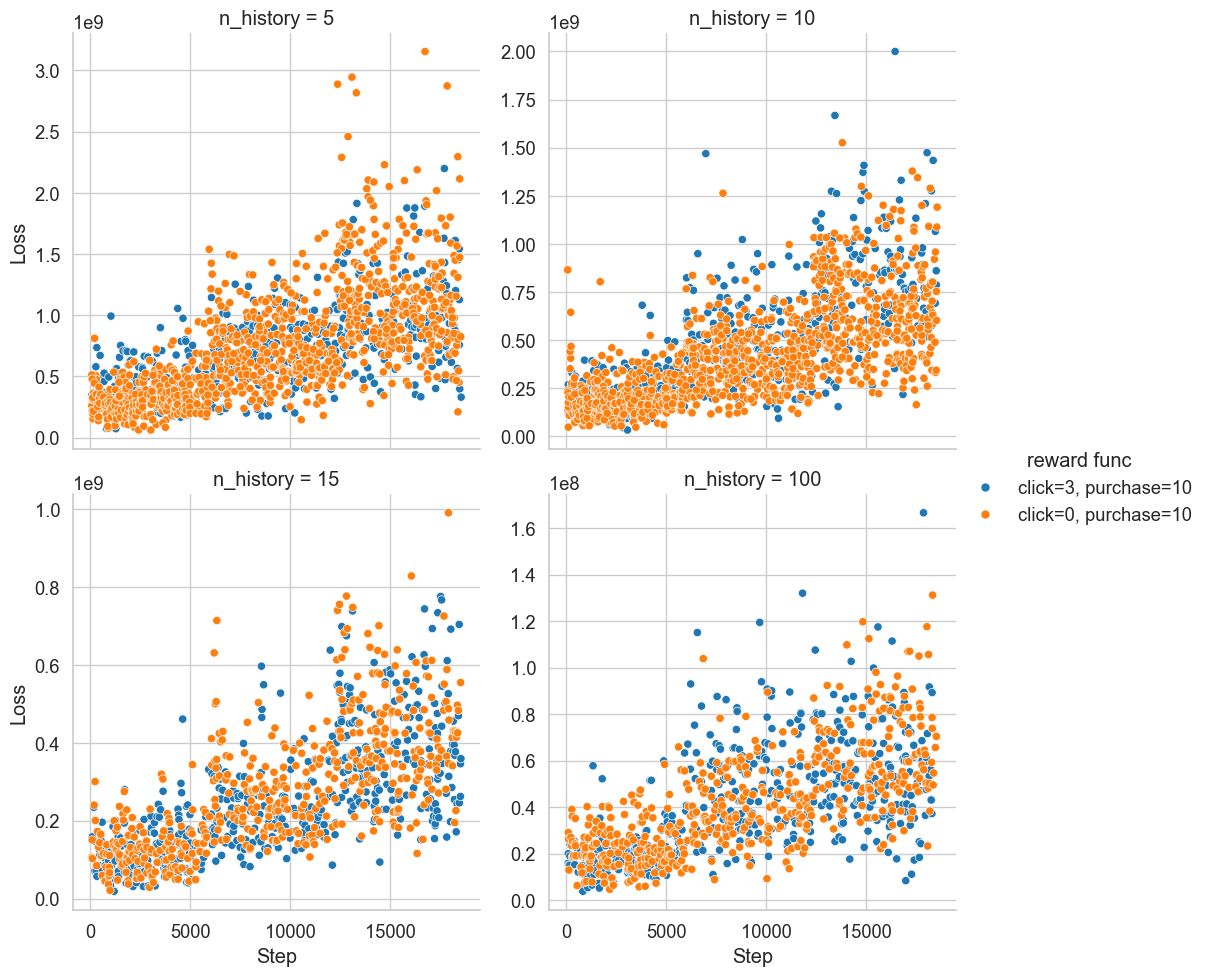

In [5]:
# visualize the loss
g = sns.relplot(data=runs_df[runs_df['reward func'].isin(['click=3, purchase=10', 'click=0, purchase=10'])],
            kind='scatter', x='_step', y='loss', 
            col='n_history', 
            col_wrap=2,
            hue='reward func',	
            palette='tab10',
            facet_kws={'sharey': False})
g.set_axis_labels("Step", "Loss")
g.savefig(plot_save_path + 'loss_per_reward_func_digi.png')

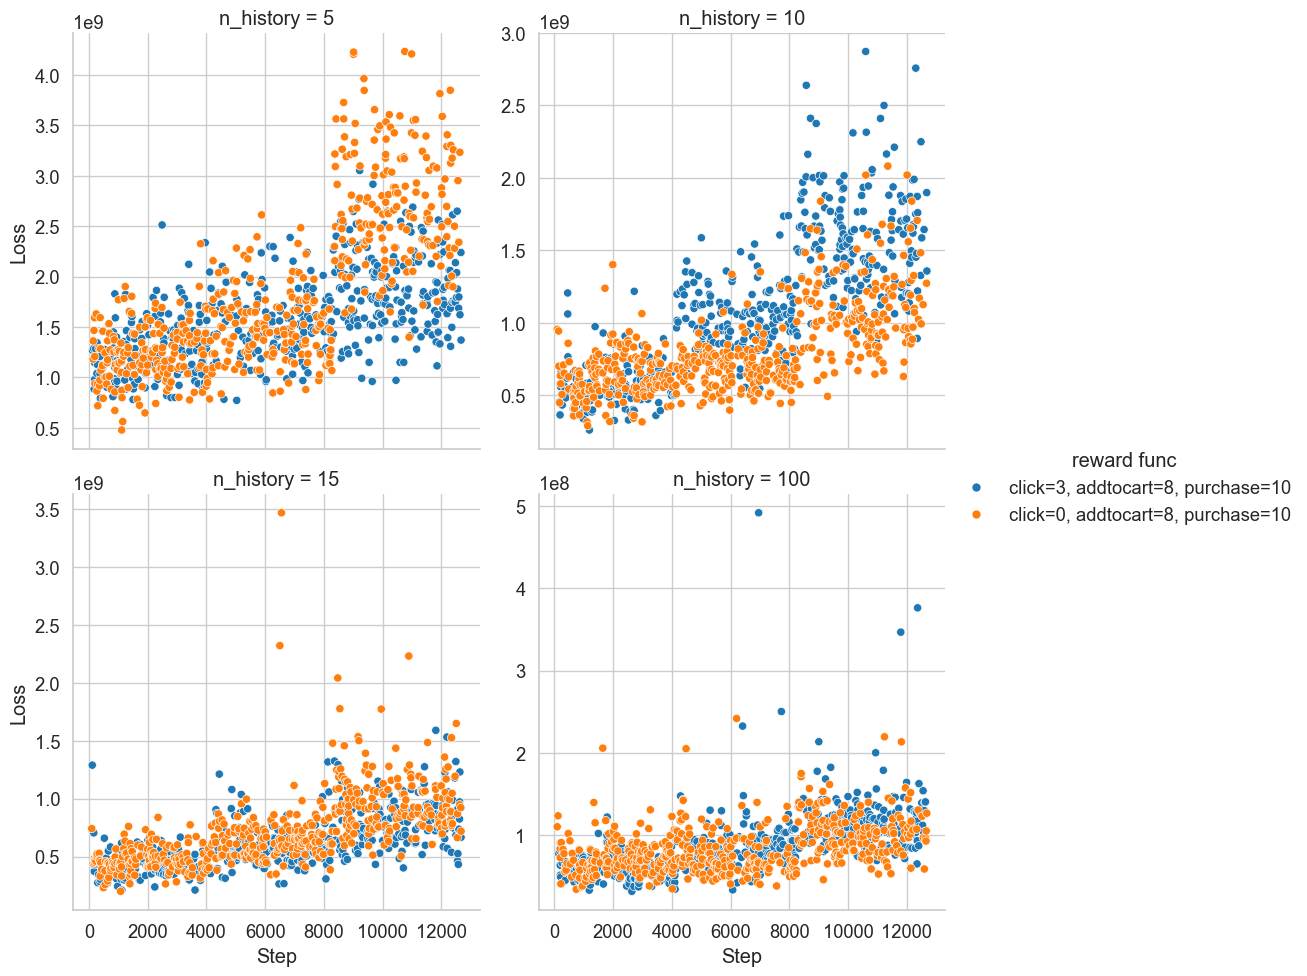

In [6]:
# visualize the loss
g = sns.relplot(data=runs_df[runs_df['reward func'].isin(['click=3, addtocart=8, purchase=10', 'click=0, addtocart=8, purchase=10'])],
            kind='scatter', x='_step', y='loss', 
            col='n_history', 
            col_wrap=2,
            hue='reward func',	
            palette='tab10',
            facet_kws={'sharey': False})
g.set_axis_labels("Step", "Loss")
g.savefig(plot_save_path + 'loss_per_reward_func_retail.png')

### Reward per episode

In [7]:
# Project is specified by <entity/project-name>
runs = api.runs("universityofappliedsciencesamsterdam/RecSys RL", filters={"tags": "selectie"}, )

summary_list, config_list, id_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    id_list.append(run.id)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "run_id": id_list
    })

# Select the columns we want to keep
cols_to_keep = ['run_id', 'dataset_name', 'reward_dict', 'n_history']

# the summary column is a dictionary we can expand it to multiple columns and keep only the columns we want
runs_df = pd.concat([runs_df.drop(['config'], axis=1), runs_df['config'].apply(pd.Series)], axis=1)[cols_to_keep]

# replace diginetica with Diginetica and retailrocket with Retailrocket
runs_df['dataset'] = runs_df['dataset_name'].str.replace('diginetica', 'Diginetica').str.replace('retailrocket', 'Retailrocket')

runs_df = runs_df.drop(['dataset_name'], axis=1)

display('runs df:')
display(runs_df)


runs = api.runs("universityofappliedsciencesamsterdam/RecSys RL", filters={"tags": "selectie"})

# Initialize a list to store the reward per episode data
data = []

# Loop through each run
for run in runs:
    # Get the run history (all steps)
    history = run.history(keys=["reward"])
    
    # Add the run id and step to the dataframe
    history["run_id"] = run.id
    history["step"] = history.index
    history["run_name"] = run.name
    
    # Append the history dataframe to the list
    data.append(history)

# Concatenate all the dataframes in the list
df = pd.concat(data)

# Reset the index of the dataframe
df.reset_index(drop=True, inplace=True)

# Display the dataframe
display('reward df:')
display(df)

'runs df:'

,run_id,reward_dict,n_history,dataset
0,un0nj4fp,"{0: 3, 1: 10}",10,Diginetica
1,qemzk45g,"{0: 3, 1: 10}",15,Diginetica
2,gdnaqjlm,"{0: 3, 1: 10}",100,Diginetica
3,yubsx58u,"{0: 0, 1: 10}",100,Diginetica
4,l4hrga4f,"{0: 3, 1: 10}",5,Diginetica
5,ymlk74xj,"{0: 0, 1: 10}",5,Diginetica
6,m6ftokad,"{0: 0, 1: 10}",10,Diginetica
7,nxovith2,"{0: 0, 1: 10}",15,Diginetica
8,w4145el8,"{0: 0, 1: 10}",5,Diginetica
9,plroqf96,"{0: 0, 1: 10}",10,Diginetica


KeyboardInterrupt: 

In [ ]:
# left join the df to the runs_df
runs_df = pd.merge(runs_df, df, on='run_id', how='left')

# Rename the reward_dict column to reward function with corresponding values
to_replace = ['{0: 3, 1: 10}', 
              '{0: 0, 1: 10}',
              '{0: 3, 1: 8, 2: 10}',
              '{0: 0, 1: 8, 2: 10}']

replace_with = ['click=3, purchase=10', 
                'click=0, purchase=10',
                'click=3, addtocart=8, purchase=10',
                'click=0, addtocart=8, purchase=10']

replacement_dict = {to_replace[i]: replace_with[i] for i in range(len(to_replace))}

runs_df['reward func'] = runs_df['reward_dict'].replace(replacement_dict, regex=True)
runs_df['reward func'].unique()

array(['click=3, purchase=10', 'click=0, purchase=10',
       'click=3, addtocart=8, purchase=10',
       'click=0, addtocart=8, purchase=10'], dtype=object)

In [ ]:
# calculate the cumulative reward
runs_df['cum_reward'] = runs_df.groupby('run_id')['reward'].transform(pd.Series.cumsum)

In [ ]:
runs_df

,run_id,reward_dict,n_history,dataset,_step,reward,step,run_name,reward func,cum_reward
0,un0nj4fp,"{0: 3, 1: 10}",10,Diginetica,2,3,0,silvery-pine-13,"click=3, purchase=10",3
1,un0nj4fp,"{0: 3, 1: 10}",10,Diginetica,14,3,1,silvery-pine-13,"click=3, purchase=10",6
2,un0nj4fp,"{0: 3, 1: 10}",10,Diginetica,26,3,2,silvery-pine-13,"click=3, purchase=10",9
3,un0nj4fp,"{0: 3, 1: 10}",10,Diginetica,67,3,3,silvery-pine-13,"click=3, purchase=10",12
4,un0nj4fp,"{0: 3, 1: 10}",10,Diginetica,74,10,4,silvery-pine-13,"click=3, purchase=10",22
...,...,...,...,...,...,...,...,...,...,...
8995,w78z63yz,"{0: 0, 1: 8, 2: 10}",100,Retailrocket,12499,0,495,effortless-star-54,"click=0, addtocart=8, purchase=10",296
8996,w78z63yz,"{0: 0, 1: 8, 2: 10}",100,Retailrocket,12510,0,496,effortless-star-54,"click=0, addtocart=8, purchase=10",296
8997,w78z63yz,"{0: 0, 1: 8, 2: 10}",100,Retailrocket,12642,0,497,effortless-star-54,"click=0, addtocart=8, purchase=10",296
8998,w78z63yz,"{0: 0, 1: 8, 2: 10}",100,Retailrocket,12643,0,498,effortless-star-54,"click=0, addtocart=8, purchase=10",296


In [ ]:
runs_df_digi = runs_df[runs_df['dataset'] == 'Diginetica'].copy()
runs_df_retail = runs_df[runs_df['dataset'] == 'Retailrocket'].copy()

# set categorical order Diginetica
order_digi = ['click=3, purchase=10', 
              'click=0, purchase=10']
runs_df_digi['reward func'] = pd.Categorical(runs_df_digi['reward func'], categories=order_digi, ordered=True)

# set categorical order Retailrocket
order_retail = ['click=3, addtocart=8, purchase=10', 
                'click=0, addtocart=8, purchase=10']
runs_df_retail['reward func'] = pd.Categorical(runs_df_retail['reward func'], categories=order_retail, ordered=True)

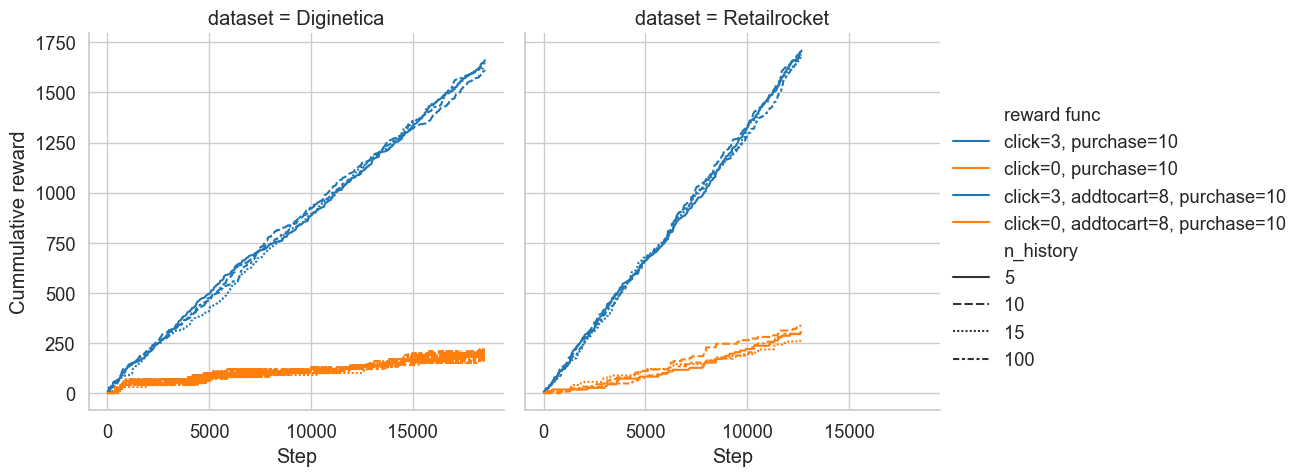

In [ ]:
g = sns.relplot(data=runs_df, kind='line', x='_step', y='cum_reward', 
            col='dataset', 
            hue='reward func',	
            style='n_history',
            # palette='tab10'
            palette=sns.color_palette("tab10", 2)+sns.color_palette("tab10", 2),
            )
g.set_axis_labels("Step", "Cummulative reward")
g.savefig(plot_save_path + 'cumulative_reward_per_step.png')

In [ ]:
runs_df_digi

,run_id,reward_dict,n_history,dataset,_step,reward,step,run_name,reward func,cum_reward
0,un0nj4fp,"{0: 3, 1: 10}",10,Diginetica,2,3,0,silvery-pine-13,"click=3, purchase=10",3
1,un0nj4fp,"{0: 3, 1: 10}",10,Diginetica,14,3,1,silvery-pine-13,"click=3, purchase=10",6
2,un0nj4fp,"{0: 3, 1: 10}",10,Diginetica,26,3,2,silvery-pine-13,"click=3, purchase=10",9
3,un0nj4fp,"{0: 3, 1: 10}",10,Diginetica,67,3,3,silvery-pine-13,"click=3, purchase=10",12
4,un0nj4fp,"{0: 3, 1: 10}",10,Diginetica,74,10,4,silvery-pine-13,"click=3, purchase=10",22
...,...,...,...,...,...,...,...,...,...,...
4995,plroqf96,"{0: 0, 1: 10}",10,Diginetica,18362,0,495,divine-donkey-41,"click=0, purchase=10",160
4996,plroqf96,"{0: 0, 1: 10}",10,Diginetica,18397,0,496,divine-donkey-41,"click=0, purchase=10",160
4997,plroqf96,"{0: 0, 1: 10}",10,Diginetica,18420,0,497,divine-donkey-41,"click=0, purchase=10",160
4998,plroqf96,"{0: 0, 1: 10}",10,Diginetica,18425,0,498,divine-donkey-41,"click=0, purchase=10",160


# Performance evaluation of hybrid session based recommendation algorithms

## Loading datasets

### Diginetica logs

In [12]:
results_diginetica = pl.read_csv("evaluation results\Diginetica*.csv").to_pandas()

results_diginetica

,Dataset,Algorithm,Reward Function,Metric,Value
0,Diginetica,RL Agent n=10,"click=0, purchase=10",MRR@2:,0.005840
1,Diginetica,RL Agent n=10,"click=0, purchase=10",MRR@3:,0.006677
2,Diginetica,RL Agent n=10,"click=0, purchase=10",MRR@4:,0.007141
3,Diginetica,RL Agent n=10,"click=0, purchase=10",MRR@5:,0.007461
4,Diginetica,RL Agent n=10,"click=0, purchase=10",MRR@10:,0.008278
...,...,...,...,...,...
106,Diginetica,VSTAN (Baseline),no reward func,HitRate@4:,0.261018
107,Diginetica,VSTAN (Baseline),no reward func,HitRate@5:,0.290980
108,Diginetica,VSTAN (Baseline),no reward func,HitRate@10:,0.387920
109,Diginetica,VSTAN (Baseline),no reward func,HitRate@15:,0.447290


In [13]:
# remove ': ' from Metric column
results_diginetica['Metric'] = results_diginetica['Metric'].str.replace(': ', '')

# print summary of available data
print(f"Tested datasets: {results_diginetica['Dataset'].unique()}")
print(f"Tested algorithms: {results_diginetica['Algorithm'].unique()}")
print(f"Variations in reward functions: {results_diginetica['Reward Function'].unique()}")
print(f"Tested metrics: {results_diginetica['Metric'].unique()}")

Tested datasets: ['Diginetica']
Tested algorithms: ['RL Agent n=10' 'RL Agent n=100' 'RL Agent n=15' 'RL Agent n=5'
 'VSTAN (Baseline)']
Variations in reward functions: ['click=0, purchase=10' 'click=3, purchase=10' 'no reward func']
Tested metrics: ['MRR@2' 'MRR@3' 'MRR@4' 'MRR@5' 'MRR@10' 'MRR@15' 'MRR@20' 'HitRate@1'
 'HitRate@2' 'HitRate@3' 'HitRate@4' 'HitRate@5' 'HitRate@10' 'HitRate@15'
 'HitRate@20']


In [15]:
# create categorical data so that the order is preserved in the plot
algorithm_order = ['VSTAN (Baseline)', 'RL Agent n=5', 'RL Agent n=10', 'RL Agent n=15', 'RL Agent n=100']
results_diginetica['Algorithm'] = pd.Categorical(results_diginetica['Algorithm'], categories=algorithm_order, ordered=True)

reward_function_order = ['no reward func', 
                         'click=3, purchase=10', 'click=0, purchase=10']
results_diginetica['Reward Function'] = pd.Categorical(results_diginetica['Reward Function'], categories=reward_function_order, ordered=True)

# Sort the results by Dataset, Algorithm and Reward Function (for better readability and comparison in visualizations)
results_diginetica = results_diginetica.sort_values(by=['Dataset', 'Algorithm', 'Reward Function']).sort_values(by=['Dataset', 'Algorithm', 'Reward Function'])

### Retailrocket

In [16]:
results_retailrocket = pl.read_csv("evaluation results\Retailrocket*.csv").to_pandas()

results_retailrocket

,Dataset,Algorithm,Reward Function,Metric,Value
0,Retailrocket,RL Agent n=10,"click=0, addtocart=8, purchase=10",MRR@2:,0.010741
1,Retailrocket,RL Agent n=10,"click=0, addtocart=8, purchase=10",MRR@3:,0.011981
2,Retailrocket,RL Agent n=10,"click=0, addtocart=8, purchase=10",MRR@4:,0.012540
3,Retailrocket,RL Agent n=10,"click=0, addtocart=8, purchase=10",MRR@5:,0.012959
4,Retailrocket,RL Agent n=10,"click=0, addtocart=8, purchase=10",MRR@10:,0.013641
...,...,...,...,...,...
106,Retailrocket,VSTAN (Baseline),no reward func,HitRate@4:,0.517926
107,Retailrocket,VSTAN (Baseline),no reward func,HitRate@5:,0.543813
108,Retailrocket,VSTAN (Baseline),no reward func,HitRate@10:,0.610499
109,Retailrocket,VSTAN (Baseline),no reward func,HitRate@15:,0.642163


In [17]:
# remove ': ' from Metric column
results_retailrocket['Metric'] = results_retailrocket['Metric'].str.replace(': ', '')

# print summary of available data
print(f"Tested datasets: {results_retailrocket['Dataset'].unique()}")
print(f"Tested algorithms: {results_retailrocket['Algorithm'].unique()}")
print(f"Variations in reward functions: {results_retailrocket['Reward Function'].unique()}")
print(f"Tested metrics: {results_retailrocket['Metric'].unique()}")

Tested datasets: ['Retailrocket']
Tested algorithms: ['RL Agent n=10' 'RL Agent n=100' 'RL Agent n=15' 'RL Agent n=5'
 'VSTAN (Baseline)']
Variations in reward functions: ['click=0, addtocart=8, purchase=10' 'click=3, addtocart=8, purchase=10'
 'no reward func']
Tested metrics: ['MRR@2' 'MRR@3' 'MRR@4' 'MRR@5' 'MRR@10' 'MRR@15' 'MRR@20' 'HitRate@1'
 'HitRate@2' 'HitRate@3' 'HitRate@4' 'HitRate@5' 'HitRate@10' 'HitRate@15'
 'HitRate@20']


In [18]:
# create categorical data so that the order is preserved in the plot
algorithm_order = ['VSTAN (Baseline)', 'RL Agent n=5', 'RL Agent n=10', 'RL Agent n=15', 'RL Agent n=100']
results_retailrocket['Algorithm'] = pd.Categorical(results_retailrocket['Algorithm'], categories=algorithm_order, ordered=True)

reward_function_order = ['no reward func', 
                         'click=3, addtocart=8, purchase=10', 
                         'click=0, addtocart=8, purchase=10']
results_retailrocket['Reward Function'] = pd.Categorical(results_retailrocket['Reward Function'], categories=reward_function_order, ordered=True)

# Sort the results by Dataset, Algorithm and Reward Function (for better readability and comparison in visualizations)
results_retailrocket = results_retailrocket.sort_values(by=['Dataset', 'Algorithm', 'Reward Function']).sort_values(by=['Dataset', 'Algorithm', 'Reward Function'])

## Visualisations of evaluation metrics

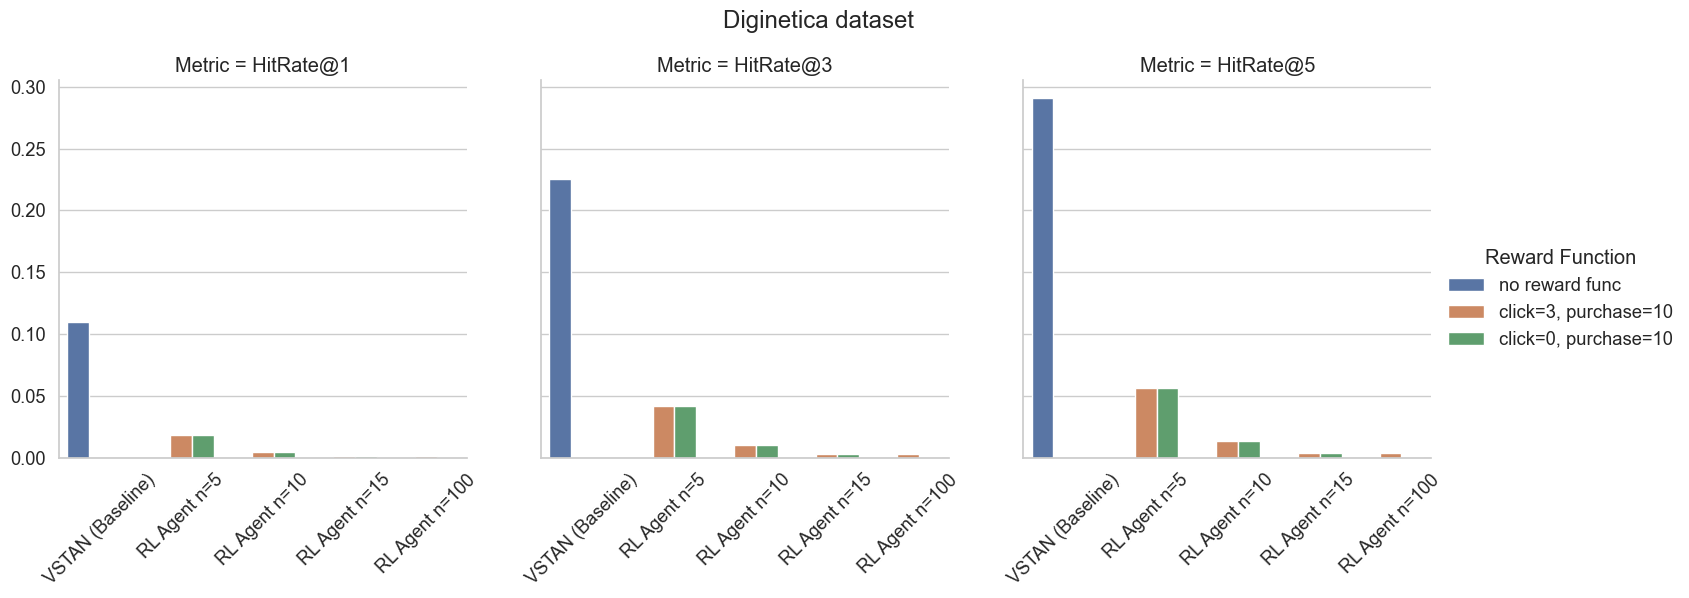

In [24]:
def plot_hitrate(results):   
    # visualize the Hit rates for list of 1 and 5
    results_selection = results[results['Metric'].isin(['HitRate@1', 'HitRate@3', 'HitRate@5'])]
    g = sns.catplot(kind='bar', data=results_selection, x='Algorithm', y='Value', hue='Reward Function', col='Metric', errorbar=None)
    g.set_axis_labels("", "")
    g.set_xticklabels(rotation=45)  
    
    dataset_name = results['Dataset'].unique()[0]
    g.fig.suptitle(f"{dataset_name} dataset", y=1.05)
    g.savefig(f'{plot_save_path}Performance evaluation Hitrate of {dataset_name}.png')


plot_hitrate(results_diginetica)

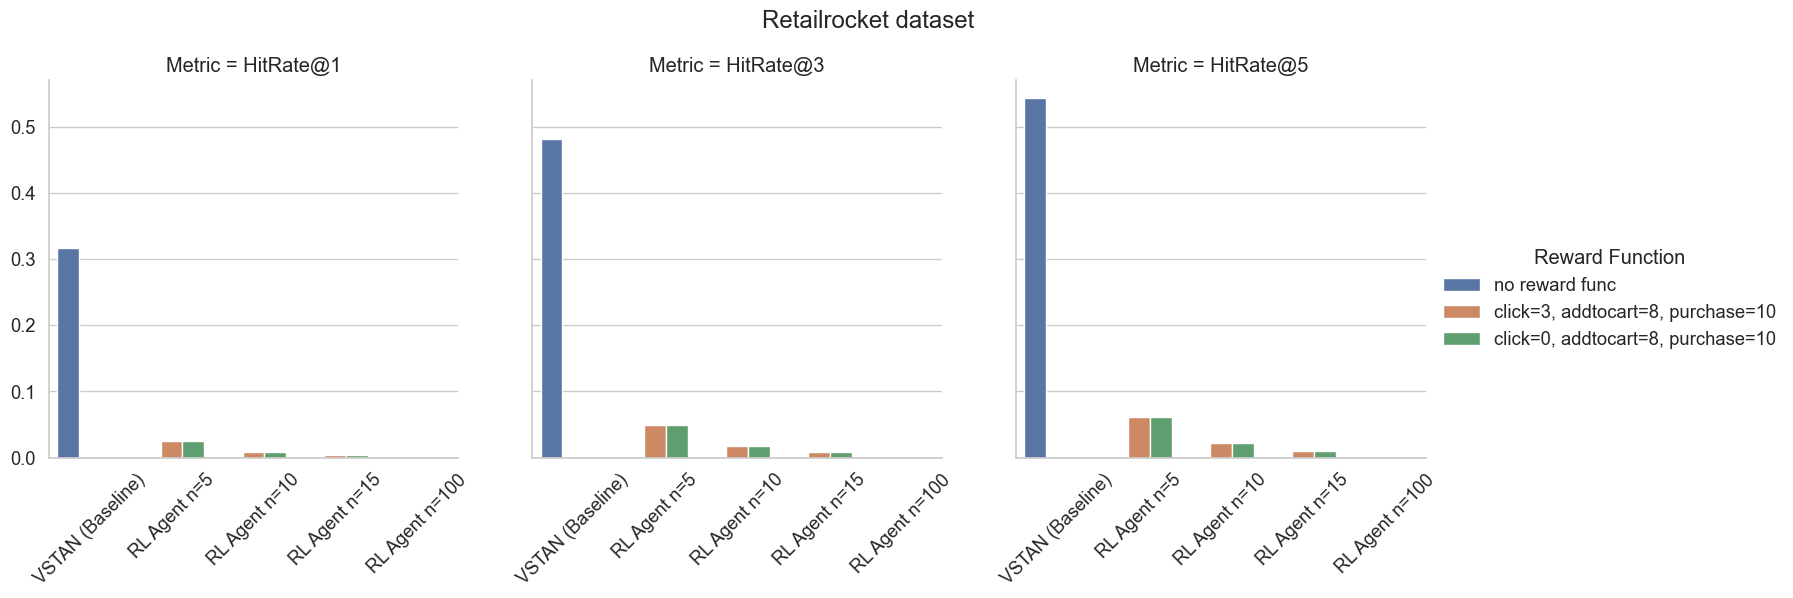

In [25]:
plot_hitrate(results_retailrocket)

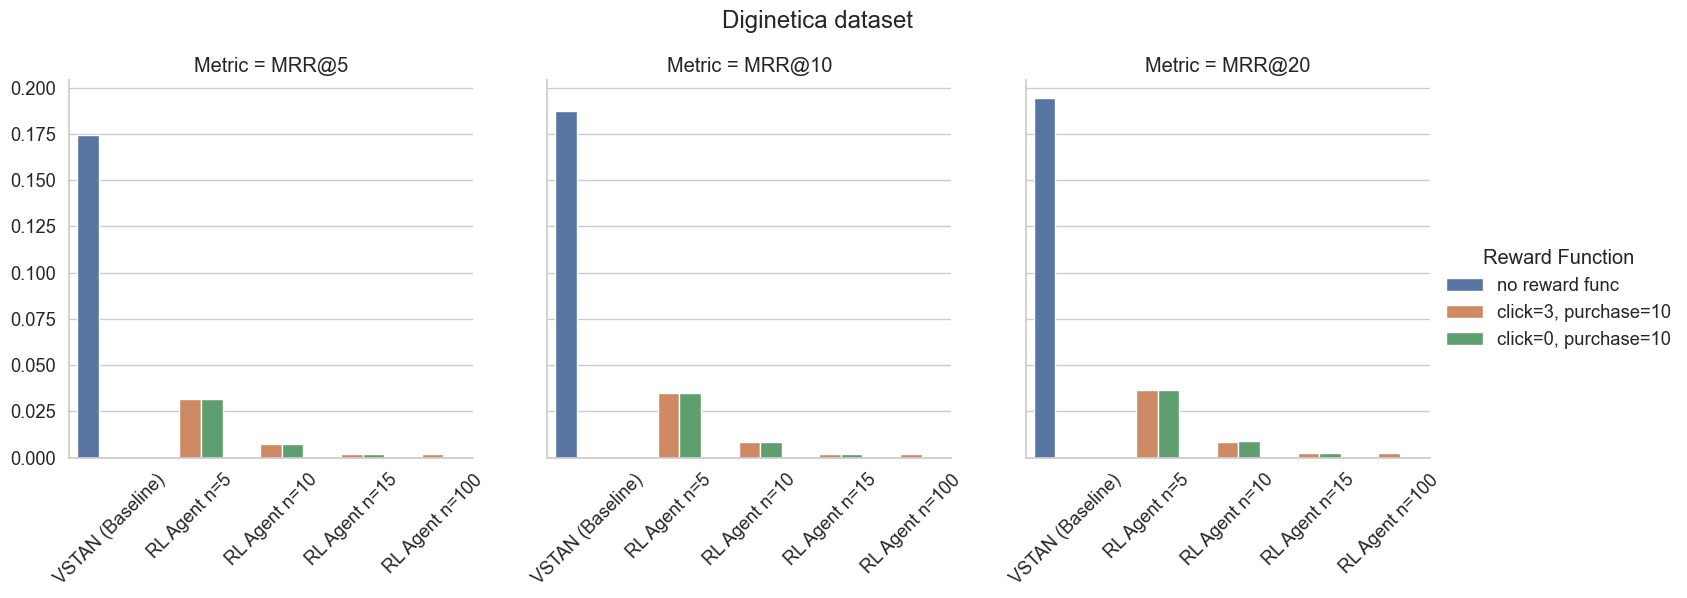

In [34]:
def plot_mrr(results):   
    results_selection = results[results['Metric'].isin(['MRR@5', 'MRR@10', 'MRR@20'])]
    g = sns.catplot(kind='bar', data=results_selection, x='Algorithm', y='Value', hue='Reward Function', col='Metric', errorbar=None)
    g.set_axis_labels("", "")
    g.set_xticklabels(rotation=45)
    
    dataset_name = results['Dataset'].unique()[0]
    g.fig.suptitle(f"{dataset_name} dataset", y=1.05)
    g.savefig(f'{plot_save_path}Performance evaluation MRR of {dataset_name}.png')
        
plot_mrr(results_diginetica)

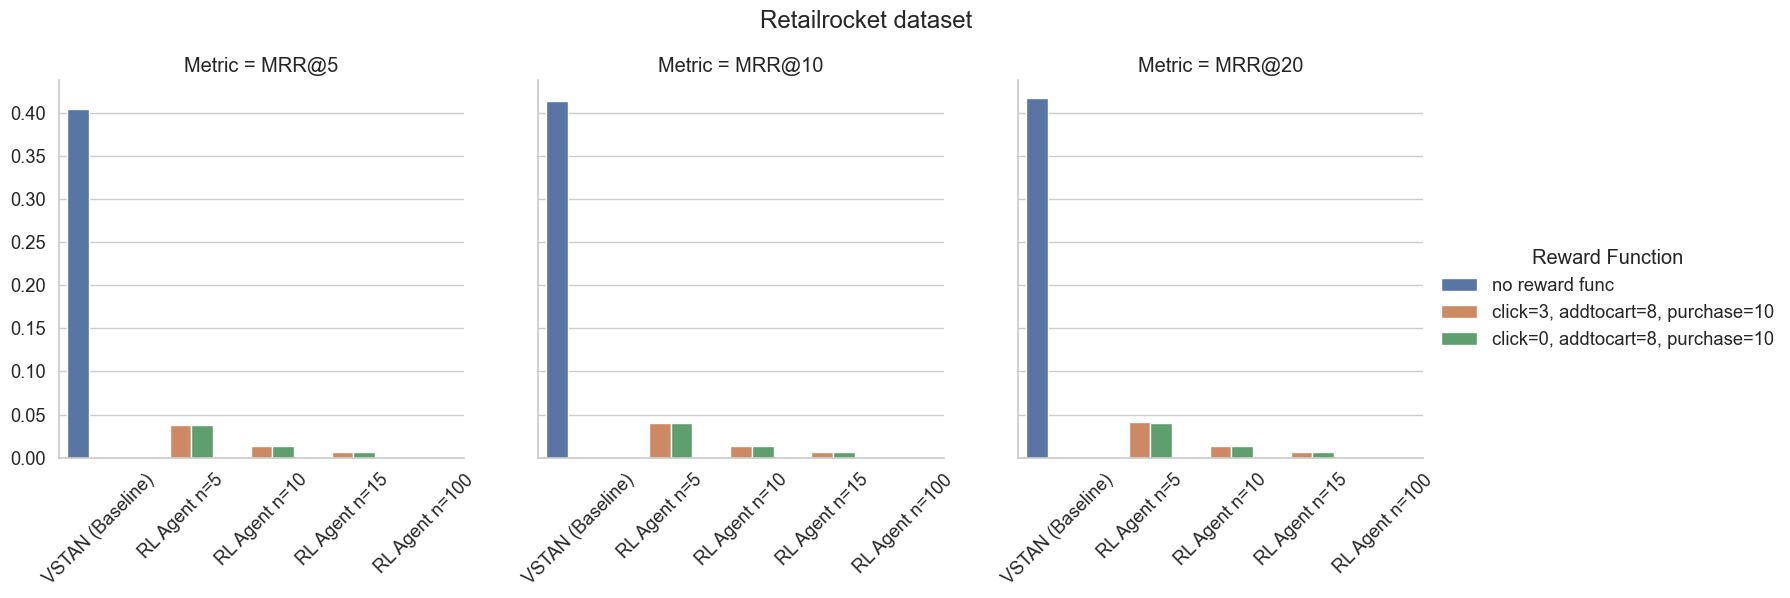

In [27]:
plot_mrr(results_retailrocket)

## Tables of evaluation metrics

In [ ]:
def pivot_table(results):
    
    dataset_name = results['Dataset'].unique()[0]
    
    metric_order = ['HitRate@1', 'HitRate@2', 'HitRate@3', 'HitRate@4', 'HitRate@5', 'HitRate@10', 'HitRate@15', 'HitRate@20',
                'MRR@2', 'MRR@3', 'MRR@4', 'MRR@5', 'MRR@10', 'MRR@15', 'MRR@20']
    results['Metric'] = pd.Categorical(results['Metric'], categories=metric_order, ordered=True)

    results['Reward Function'].str.replace(', ', ',\n')

    # convert metric into two columns based on Value
    results_pivot = results.pivot(index=['Dataset', 'Algorithm', 'Reward Function'], columns='Metric', values='Value')

    # replace nan values with ''
    results_pivot = results_pivot.fillna('')

    # remove HitRate@10, HitRate@15, HitRate@20, as columns
    results_pivot = results_pivot.drop(columns=['HitRate@10', 'HitRate@15', 'HitRate@20'])
    
    results_pivot = round(results_pivot, 4).T
    
    # convert to latex table and save it
    results_pivot.to_latex(f'{table_save_path}Evaluation metrics of {dataset_name} dataset.tex')

    return results_pivot

pivot_table(results_diginetica)

Dataset               Diginetica                                            \
Algorithm       VSTAN (Baseline)         RL Agent n=5                        
Reward Function   no reward func click=3, purchase=10 click=0, purchase=10   
Metric                                                                       
HitRate@1                 0.1094               0.0180               0.0180   
HitRate@2                 0.1789               0.0319               0.0319   
HitRate@3                 0.2251               0.0417               0.0417   
HitRate@4                 0.2610               0.0496               0.0497   
HitRate@5                 0.2910               0.0562               0.0562   
MRR@2                     0.1442               0.0250               0.0249   
MRR@3                     0.1596               0.0282               0.0282   
MRR@4                     0.1685               0.0302               0.0302   
MRR@5                     0.1745               0.0315               0.0315   
MRR@10                    0.1875               0.0348               0.0348   
MRR@15                    0.1922               0.0362               0.0361   
MRR@20                    0.1944               0.0368               0.0368   

Dataset                                                    \
Algorithm              RL Agent n=10                        
Reward Function click=3, purchase=10 click=0, purchase=10   
Metric                                                      
HitRate@1                     0.0042               0.0042   
HitRate@2                     0.0075               0.0075   
HitRate@3                     0.0099               0.0100   
HitRate@4                     0.0117               0.0118   
HitRate@5                     0.0132               0.0134   
MRR@2                         0.0058               0.0058   
MRR@3                         0.0067               0.0067   
MRR@4                         0.0071               0.0071   
MRR@5                         0.0074               0.0075   
MRR@10                        0.0082               0.0083   
MRR@15                        0.0085               0.0086   
MRR@20                        0.0087               0.0088   

Dataset                                                    \
Algorithm              RL Agent n=15                        
Reward Function click=3, purchase=10 click=0, purchase=10   
Metric                                                      
HitRate@1                     0.0012               0.0011   
HitRate@2                     0.0021               0.0021   
HitRate@3                     0.0026               0.0026   
HitRate@4                     0.0031               0.0030   
HitRate@5                     0.0034               0.0034   
MRR@2                         0.0017               0.0016   
MRR@3                         0.0018               0.0018   
MRR@4                         0.0019               0.0019   
MRR@5                         0.0020               0.0020   
MRR@10                        0.0022               0.0022   
MRR@15                        0.0023               0.0023   
MRR@20                        0.0024               0.0024   

Dataset                                                    
Algorithm             RL Agent n=100                       
Reward Function click=3, purchase=10 click=0, purchase=10  
Metric                                                     
HitRate@1                     0.0012               0.0001  
HitRate@2                     0.0021               0.0002  
HitRate@3                     0.0026               0.0002  
HitRate@4                     0.0031               0.0003  
HitRate@5                     0.0034               0.0004  
MRR@2                         0.0017               0.0001  
MRR@3                         0.0018               0.0001  
MRR@4                         0.0019               0.0002  
MRR@5                         0.0020               0.0002  
MRR@10           

In [ ]:
pivot_table(results_retailrocket)

Dataset             Retailrocket                                    \
Algorithm       VSTAN (Baseline)                      RL Agent n=5   
Reward Function   no reward func click=3, addtocart=8, purchase=10   
Metric                                                               
HitRate@1                 0.3176                            0.0250   
HitRate@2                 0.4260                            0.0401   
HitRate@3                 0.4822                            0.0497   
HitRate@4                 0.5179                            0.0560   
HitRate@5                 0.5438                            0.0611   
MRR@2                     0.3718                            0.0325   
MRR@3                     0.3905                            0.0357   
MRR@4                     0.3995                            0.0373   
MRR@5                     0.4046                            0.0383   
MRR@10                    0.4137                            0.0399   
MRR@15                    0.4162                            0.0404   
MRR@20                    0.4174                            0.0407   

Dataset                                            \
Algorithm                                           
Reward Function click=0, addtocart=8, purchase=10   
Metric                                              
HitRate@1                                  0.0249   
HitRate@2                                  0.0401   
HitRate@3                                  0.0497   
HitRate@4                                  0.0559   
HitRate@5                                  0.0610   
MRR@2                                      0.0325   
MRR@3                                      0.0357   
MRR@4                                      0.0373   
MRR@5                                      0.0383   
MRR@10                                     0.0399   
MRR@15                                     0.0404   
MRR@20                                     0.0407   

Dataset                                            \
Algorithm                           RL Agent n=10   
Reward Function click=3, addtocart=8, purchase=10   
Metric                                              
HitRate@1                                  0.0079   
HitRate@2                                  0.0136   
HitRate@3                                  0.0173   
HitRate@4                                  0.0196   
HitRate@5                                  0.0217   
MRR@2                                      0.0108   
MRR@3                                      0.0120   
MRR@4                                      0.0126   
MRR@5                                      0.0130   
MRR@10                                     0.0137   
MRR@15                                     0.0138   
MRR@20                                     0.0139   

Dataset                                            \
Algorithm                                           
Reward Function click=0, addtocart=8, purchase=10   
Metric                                              
HitRate@1                                  0.0079   
HitRate@2                                  0.0136   
HitRate@3                                  0.0173   
HitRate@4                                  0.0195   
HitRate@5                                  0.0216   
MRR@2                                      0.0107   
MRR@3                                      0.0120   
MRR@4                                      0.0125   
MRR@5                                      0.0130   
MRR@10                                     0.0136   
MRR@15                                     0.0138   
MRR@20                                     0.0139   

Dataset                                            \
Algorithm                           RL Agent n=15   
Reward Function click=3, addtocart=8, purchase=10   
Metric                                              
HitRate@1                                  0.0036   
HitRate@2                                  0.0065   
HitRate@3     